# Spectral Clustering

This implementation of spectral clustering is based on the wiki.

In [1]:
from sklearn import datasets

iris = datasets.load_iris()

In [2]:
%matplotlib inline
iris.data.shape, iris.target.shape

((150, 4), (150,))

In [3]:
import numpy as np
from sklearn.cluster import KMeans

def spectral_cluster(X, n_clusters=3, sigma=1, k=5):
    def graph_building_KNN(X, k=5, sigma=1):
        N = len(X)
        S = np.zeros((N, N))
        for i, x in enumerate(X):
            S[i] = np.array([np.linalg.norm(x - xi) for xi in X])
            S[i][i] = 0
        
        graph = np.zeros((N, N))
        for i, x in enumerate(X):
            distance_top_n = np.argsort(S[i])[1: k+1]
            for nid in distance_top_n:
                graph[i][nid] = np.exp(-S[i][nid] / (2 * sigma ** 2))
        return graph
    
    graph = graph_building_KNN(X, k)
    
    def laplacianMatrix(A):
        dm = np.sum(A, axis=1)
        D = np.diag(dm)
        L = D - A
        sqrtD = np.diag(1.0 / (dm ** 0.5))
        return np.dot(np.dot(sqrtD, L), sqrtD)
    
    L = laplacianMatrix(graph)
    
    def smallNeigen(L, n_eigen):
        eigval, eigvec = np.linalg.eig(L)
        index = list(map(lambda x: x[1], sorted(zip(eigval, range(len(eigval))))[1:n_eigen]))
        return eigvec[:, index]
    H = smallNeigen(L, k)
    kmeans = KMeans(n_clusters=n_clusters).fit(H)
    return kmeans.labels_

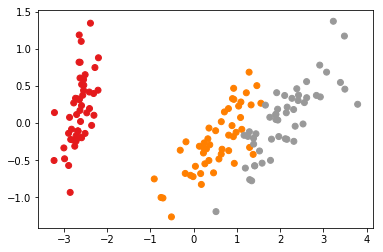

In [4]:
from sklearn import datasets
iris = datasets.load_iris()
from sklearn.decomposition import PCA
X_reduced = PCA(n_components=2).fit_transform(iris.data)

y = iris.target
import matplotlib.pyplot as plt
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y, cmap=plt.cm.Set1)

c:\users\lijy2\appdata\local\programs\python\python36\lib\site-packages\sklearn\utils\validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)


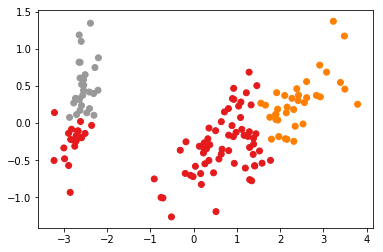

In [5]:
y = spectral_cluster(iris.data, n_clusters=3, sigma=0.8)
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y, cmap=plt.cm.Set1)

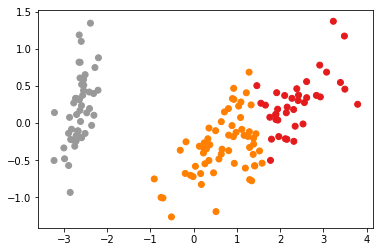

In [6]:
from sklearn.cluster import SpectralClustering

clustering = SpectralClustering(n_clusters=3,
        assign_labels="kmeans",
        random_state=0).fit(X_reduced)
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=clustering.labels_, cmap=plt.cm.Set1)

In [7]:
def evaluate(y, t):
    a, b, c, d = [0 for i in range(4)]
    for i in range(len(y)):
        for j in range(i+1, len(y)):
            if y[i] == y[j] and t[i] == t[j]:
                a += 1
            elif y[i] == y[j] and t[i] != t[j]:
                b += 1
            elif y[i] != y[j] and t[i] == t[j]:
                c += 1
            elif y[i] != y[j] and t[i] != t[j]:
                d += 1
    return a, b, c, d

def external_index(a, b, c, d, m):
    JC = a / (a + b + c)
    FMI = np.sqrt(a**2 / ((a + b) * (a + c)))
    RI = 2 * ( a + d ) / ( m * (m + 1) )
    return JC, FMI, RI

def evaluate_it(y, t):
    a, b, c, d = evaluate(y, t)
    return external_index(a, b, c, d, len(y))

In [8]:
evaluate_it(y, iris.target)

(0.43047158403869407, 0.6056997570469922, 0.6956291390728477)